Neural Network Model with 3 Hidden Layers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors, build_vocab_from_iterator
from torchtext.vocab import GloVe

from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryPrecision
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay

from nltk.corpus import stopwords

In [2]:
df = pd.read_csv("data/ML_text_data_new.csv")

Create list of stop words to exclude from vocabulary

In [3]:
stop_words = set(stopwords.words('english'))

In [4]:
stop_words.update(['.', ',', '(', ')', '--', 'hba', 'sba', 'hb', 'sb', 'house', 'senate', 'session'
                   'hbb', 'sshb', '-ls\\s', '-ls\\a', 'sbb', 'cssb', 'cra', '-ls\\b', 'legislature'])

Convert data to list of tuples

In [5]:
data_raw = zip(df['discriminatory'], df['text'])

In [6]:
data = [(label, tokens) for (label, tokens) in data_raw] 

In [7]:
len(data)

2660

In [8]:
data_iter = iter(data)
next(data_iter)

(0,
 '  Enrolled HB  LAWS OF ALASKA            Source Chapter No.  CSHB (FIN) _______        AN ACT    Making supplemental appropriati ons and other appropriations; ma king appropriations under  art. IX, sec. (c), Constitution of the State of Alaska, from the constitutional budget reserve  fund; and providing for  an effective date.     _______________     BE IT ENACTED BY THE LEGISLATURE OF THE STATE OF ALASKA:      THE ACT FOLLOWS ON PAGE    -- Enrolled HB                        AN ACT     Making supplemental appropriati ons and other appropriations; ma king appropriations under   art. IX, sec. (c), Constitution of the State of Alaska, from the constitutional budget reserve   fund; and providing for  an effective date.   _______________   (SECTION  OF THIS ACT BEGINS ON PAGE )      CSHB (FIN), Sec.      -  -     * Section . The following appropriation items  are for operating expenditure s from the   general fund or other funds as set out in the fiscal year  budget summary for the   

In [9]:
def clean_text(text):
    '''
    Function the removes frequent phrases from text that
    are not relevant to text classifcation
    '''
    text = text.replace("\n", " ")
    text = text.replace("New Text Underlined", "")
    text = text.replace("[DELETED TEXT BRACKETED]", "")
    text = re.sub(" {2,}", " ", text)
    return text

In [10]:
tokenizer = get_tokenizer('basic_english')

In [11]:
#check code for yield_tokens function to see in appropriate tokens are generated
for i, (_, text) in enumerate(data_iter):
    text = clean_text(text)
    text = tokenizer(text)
    text = [w for w in text if w not in stop_words]
    print(text)
    if i == 2:
        break

['bill', 'state', 'alaska', 'thirty-third', '-', 'first', 'session', 'representatives', 'wright', 'groh', 'fields', 'mccormick', 'armstrong', 'introduced', '//', 'referred', 'state', 'affairs', 'labor', 'commerce', 'bill', 'act', 'entitled', 'act', 'establishing', 'junet', 'eenth', 'day', 'legal', 'holiday', 'enacted', 'state', 'alaska', '*', 'section', 'amended', 'read', 'following', 'days', 'legal', 'holidays', 'first', 'january', 'k', 'nown', 'new', 'year', "'", 'day', 'third', 'monday', 'january', 'known', 'martin', 'luther', 'king', 'jr', "'", 'birthday', 'provided', 'b', 'section', 'third', 'monday', 'february', 'known', 'presidents', "'", 'day', 'last', 'monday', 'march', 'known', 'seward', "'", 'day', 'last', 'monday', 'may', 'known', 'memorial', 'day', 'th', 'june', 'kno', 'wn', 'juneteenth', 'day', '[', ']', 'fourth', 'july', 'known', 'independence', 'day', '[', ']', 'first', 'monday', 'sep', 'tember', 'known', 'labor', 'day', '[', ']', 'th', 'october', 'known', 'alaska', 'da

In [12]:
def yield_tokens(data_iter):
    '''
    Function that creates list of tokens from string of text
    '''
    for _, text in data_iter:
        text = clean_text(text)
        text = tokenizer(text)
        text = [w for w in text if w not in stop_words]
        yield text

Build vocabularly

In [13]:
vocab = build_vocab_from_iterator(
    yield_tokens(data), specials=["<unk>"], min_freq=100)

In [14]:
vocab.set_default_index(vocab["<unk>"])

In [15]:
# Checking the result
print(len(vocab))
print(vocab.lookup_token(0))
print(vocab.lookup_token(15))
print(vocab["bill"])
print(vocab["gender"])
print(vocab["pronoun"])
print(vocab["transgender"])

3884
<unk>
provided
55
109
2314
3486


Create collate function for data builder

In [16]:
def collate_fn(batch):
    labels = torch.tensor([x[0] for x in batch])
    tokens = [tokenizer(x[1]) for x in batch]
    cbow = [] 
    for t in tokens:
        indx = [vocab[token] for token in t]
        bow = [0] * len(vocab)
        for i in indx:
            bow[i] = bow[i] + 1/len(tokens)
        cbow.append(bow)
    return labels, torch.tensor(cbow)

Build neural network model

In [17]:
class NNClassifier(nn.Module):
    def __init__(self,
                 vocab_size, 
                 hidden_dim1,
                 hidden_dim2,
                 hidden_dim3, 
                 output_dim,
                 nonlinearity):      
        super(NNClassifier, self).__init__()

        self.linear1 = nn.Linear(vocab_size, hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        self.nonlinearity = nonlinearity
        self.output = nn.Sigmoid()

    def forward(self, word_idxs_batch):
        z = self.linear1(word_idxs_batch)
        h = self.nonlinearity(z)
        z2 = self.linear2(h)
        h2 = self.nonlinearity(z2)
        z3 = self.linear3(h2)
        h3 = self.nonlinearity(z3)
        z4 = self.linear4(h3)
        y = self.output(z4)
        return y.reshape(-1)

In [18]:
model = NNClassifier(vocab_size = len(vocab),
                     hidden_dim1 = 128,
                     hidden_dim2 = 128,
                     hidden_dim3 =  54,
                     output_dim = 1,
                     nonlinearity = nn.Sigmoid())

   Create functions to train model and evaluate performance

In [19]:
loss_function = nn.CrossEntropyLoss()

def train_an_epoch(dataloader, optimizer):
    '''
    Function that takes in data and a optimizer and executes the model training steps
    '''
    model.train() 
    log_interval = 50

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label.type('torch.FloatTensor'))
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [20]:
def get_probabilites(dataloader):
    '''
    Function that takes in data and inputs it into a trained model 
    Returns list of labels and predicted probailities of label being 1
    '''
    model.eval()
    y_list = []
    y_pred_list = []
    with torch.no_grad(): 
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model(word_idxs)
            y_list.append(label)
            y_pred_list.append(log_probs)
    y = torch.cat(y_list, dim=0)
    y_pred = torch.cat(y_pred_list, dim=0)
    return y, y_pred

In [21]:
def get_accuracy(dataloader):
    '''
    Function that takes in data and inputs it into a trained model 
    Returns accuracy, recall, and precision of model predictions
    '''
    model.eval()
    with torch.no_grad():    
        total_acc, total_count = 0, 0
        all_recall = []
        all_precision = []
        recall_metric = BinaryRecall()
        precision_metric = BinaryPrecision()
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model(word_idxs)
            total_acc += (log_probs.round() == label).sum().item()
            total_count += label.size(0)
            recall = recall_metric(log_probs, label)
            precision = precision_metric(log_probs, label)
            all_recall.append(recall)
            all_precision.append(precision)
    accuracy = total_acc/total_count

    return accuracy, np.mean(all_recall), np.mean(all_precision)

Prepare training, validation, and test data sets.

In [22]:
# Prep for data split
len_train = int(len(data) * .8)
len_valid = int((len(data) - len_train)/2)
len_test = len(data) - len_train - len_valid
print(len_train, "train", len_valid, "validation", len_test, "testing")

2128 train 266 validation 266 testing


In [23]:
BATCH_SIZE = 16

train_data, valid_data, test_data = random_split(
    data, [len_train, len_valid, len_test])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

Execute model training - sigmoid non-linearity

At iteration 50 the loss is 11.090.
At iteration 100 the loss is 13.832.
Epoch: 1, time taken: 22.7s, validation accuracy: 
          0.320, recall: 1.0, precision: 0.31470587849617004.
At iteration 50 the loss is 13.741.
At iteration 100 the loss is 16.349.
Epoch: 2, time taken: 19.8s, validation accuracy: 
          0.789, recall: 0.688141942024231, precision: 0.6601774096488953.
At iteration 50 the loss is 16.313.
At iteration 100 the loss is 5.485.
Epoch: 3, time taken: 19.8s, validation accuracy: 
          0.861, recall: 0.686274528503418, precision: 0.8606442809104919.
At iteration 50 the loss is 12.146.
At iteration 100 the loss is 12.335.
Epoch: 4, time taken: 19.4s, validation accuracy: 
          0.872, recall: 0.722455620765686, precision: 0.8705881834030151.
At iteration 50 the loss is 17.101.
At iteration 100 the loss is 17.094.
Epoch: 5, time taken: 20.5s, validation accuracy: 
          0.898, recall: 0.7971054315567017, precision: 0.8768907189369202.
At iteration 50 th

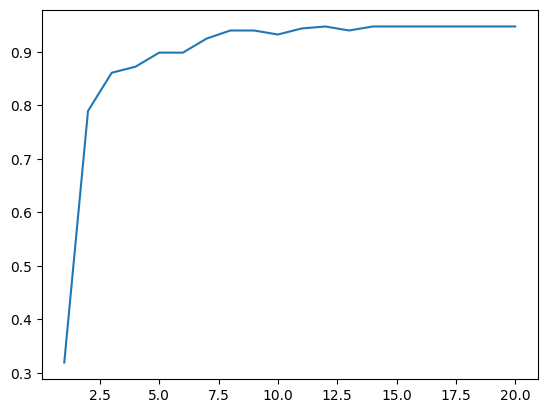

In [24]:
#sigmoid model train
import time
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 20 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies_val_sig=[]
recalls_val_sig=[]
precisions_val_sig=[]
accuracies_train_sig=[]
recalls_train_sig=[]
precisions_train_sig=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy_val, recall_val, precision_val = get_accuracy(valid_dataloader)
    accuracy_train, recall_train, precision_train = get_accuracy(train_dataloader)
    accuracies_val_sig.append(accuracy_val)
    recalls_val_sig.append(recall_val)
    precisions_val_sig.append(precision_val)
    accuracies_train_sig.append(accuracy_train)
    recalls_train_sig.append(recall_train)
    precisions_train_sig.append(precision_train)
    time_taken = time.time() - epoch_start_time
    print(f'''Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: 
          {accuracy_val:.3f}, recall: {recall_val}, precision: {precision_val}.''')
    
plt.plot(range(1, EPOCHS+1), accuracies_val_sig)

accuracy, recall, precision = get_accuracy(test_dataloader)
y, y_prob = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

Text(0, 0.5, 'Accuracy')

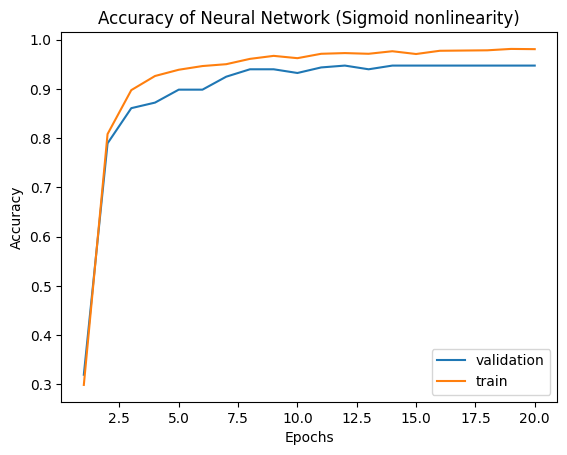

In [25]:
plt.plot(range(1, EPOCHS+1), accuracies_val_sig, label='validation')
plt.plot(range(1, EPOCHS+1), accuracies_train_sig, label='train')
plt.title('Accuracy of Neural Network (Sigmoid nonlinearity)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Recall')

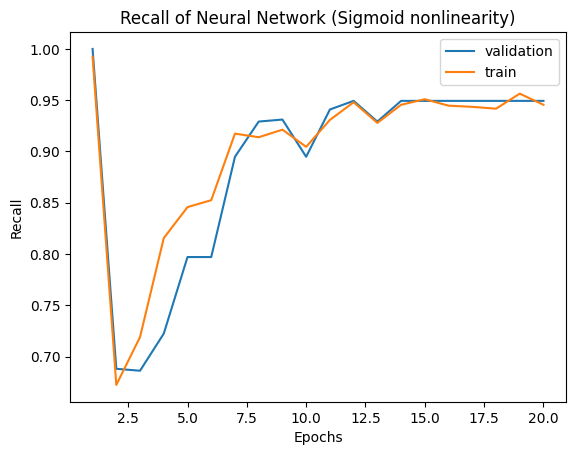

In [26]:
plt.plot(range(1, EPOCHS+1), recalls_val_sig, label='validation')
plt.plot(range(1, EPOCHS+1), recalls_train_sig, label='train')
plt.title('Recall of Neural Network (Sigmoid nonlinearity)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Recall')

Text(0, 0.5, 'Precision')

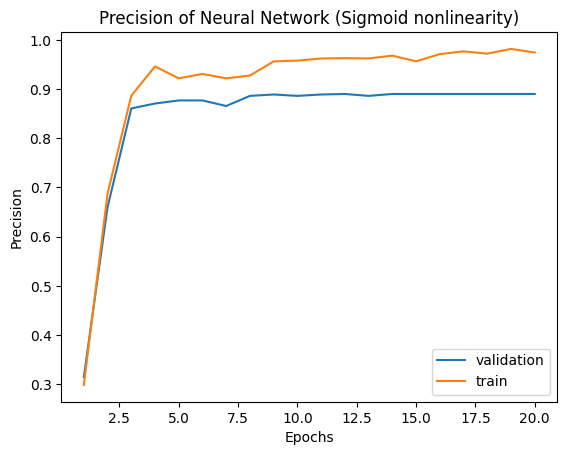

In [27]:
plt.plot(range(1, EPOCHS+1), precisions_val_sig, label='validation')
plt.plot(range(1, EPOCHS+1), precisions_train_sig, label='train')
plt.title('Precision of Neural Network (Sigmoid nonlinearity)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Precision')

In [28]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [29]:
y_pred = [y.round() for y in y_prob]
cf_mat = confusion_matrix(y, y_pred)

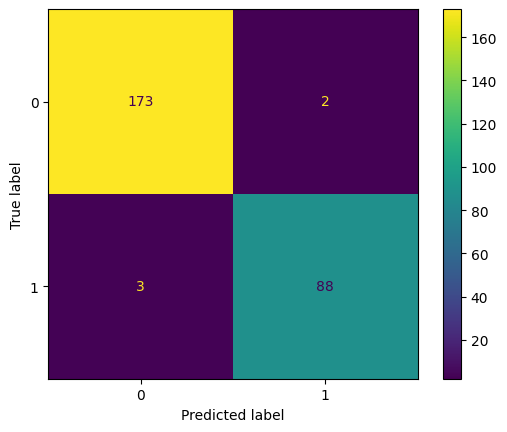

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat)
disp.plot()
plt.show()

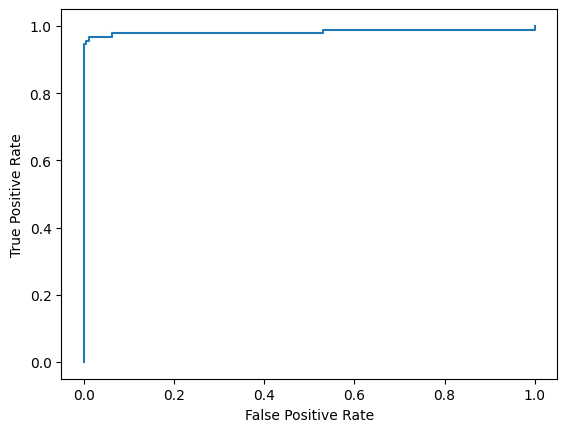

In [31]:
plot_roc_curve(y, y_prob)

Create neural network model with ReLU non-linearity

In [32]:
model = NNClassifier(vocab_size = len(vocab),
                     hidden_dim1 = 128,
                     hidden_dim2 = 128,
                     hidden_dim3 =  54,
                     output_dim = 1,
                     nonlinearity = nn.ReLU())

In [33]:
BATCH_SIZE = 16

train_data, valid_data, test_data = random_split(
    data, [len_train, len_valid, len_test])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

At iteration 50 the loss is 10.864.
At iteration 100 the loss is 2.626.
Epoch: 1, time taken: 16.4s, validation accuracy: 
          0.455, recall: 0.926237165927887, precision: 0.34885668754577637.
At iteration 50 the loss is 2.507.
At iteration 100 the loss is 16.020.
Epoch: 2, time taken: 16.6s, validation accuracy: 
          0.880, recall: 0.8480625748634338, precision: 0.7640756964683533.
At iteration 50 the loss is 9.821.
At iteration 100 the loss is 17.456.
Epoch: 3, time taken: 16.1s, validation accuracy: 
          0.921, recall: 0.8333566784858704, precision: 0.918067216873169.
At iteration 50 the loss is 17.064.
At iteration 100 the loss is 6.976.
Epoch: 4, time taken: 16.6s, validation accuracy: 
          0.895, recall: 0.9005835652351379, precision: 0.8127451539039612.
At iteration 50 the loss is 8.890.
At iteration 100 the loss is 11.302.
Epoch: 5, time taken: 16.3s, validation accuracy: 
          0.932, recall: 0.9005835652351379, precision: 0.8984593749046326.
At ite

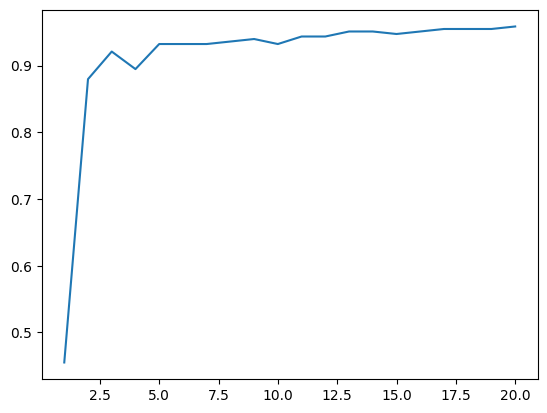

In [34]:
#model using ReLU nonlinearity for hidden layers
%matplotlib inline

EPOCHS = 20 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies_val_relu=[]
recalls_val_relu=[]
precisions_val_relu=[]
accuracies_train_relu=[]
recalls_train_relu=[]
precisions_train_relu=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy_val, recall_val, precision_val = get_accuracy(valid_dataloader)
    accuracy_train, recall_train, precision_train = get_accuracy(train_dataloader)
    accuracies_val_relu.append(accuracy_val)
    recalls_val_relu.append(recall_val)
    precisions_val_relu.append(precision_val)
    accuracies_train_relu.append(accuracy_train)
    recalls_train_relu.append(recall_train)
    precisions_train_relu.append(precision_train)
    time_taken = time.time() - epoch_start_time
    print(f'''Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: 
          {accuracy_val:.3f}, recall: {recall_val}, precision: {precision_val}.''')
    
plt.plot(range(1, EPOCHS+1), accuracies_val_relu)

accuracy_relu, recall_relu, precision_relu = get_accuracy(test_dataloader)
y_relu, y_prob_relu = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy_relu:.3f}, recall {recall_relu}, precision {precision_relu}.')

Text(0, 0.5, 'Accuracy')

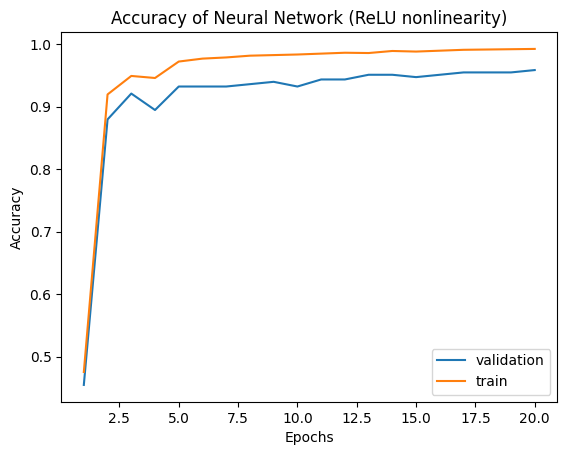

In [35]:
plt.plot(range(1, EPOCHS+1), accuracies_val_relu, label='validation')
plt.plot(range(1, EPOCHS+1), accuracies_train_relu, label='train')
plt.title('Accuracy of Neural Network (ReLU nonlinearity)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Recall')

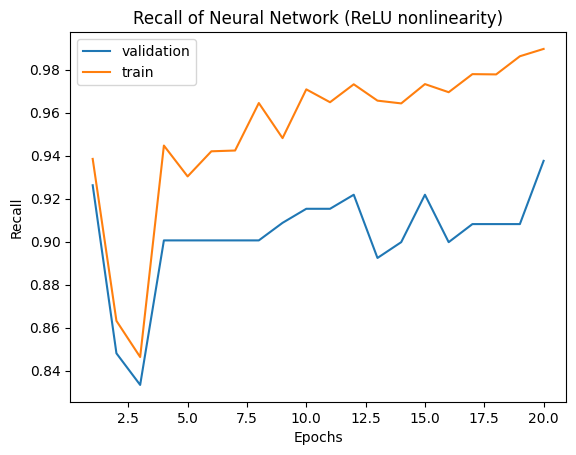

In [36]:
plt.plot(range(1, EPOCHS+1), recalls_val_relu, label='validation')
plt.plot(range(1, EPOCHS+1), recalls_train_relu, label='train')
plt.title('Recall of Neural Network (ReLU nonlinearity)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Recall')

Text(0, 0.5, 'Precision')

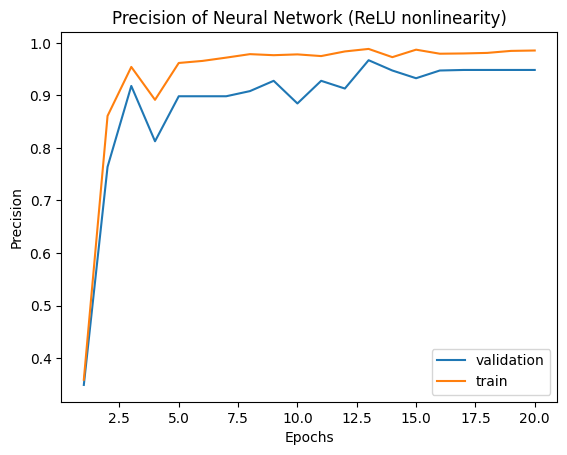

In [37]:
plt.plot(range(1, EPOCHS+1), precisions_val_relu, label='validation')
plt.plot(range(1, EPOCHS+1), precisions_train_relu, label= 'train')
plt.title('Precision of Neural Network (ReLU nonlinearity)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Precision')

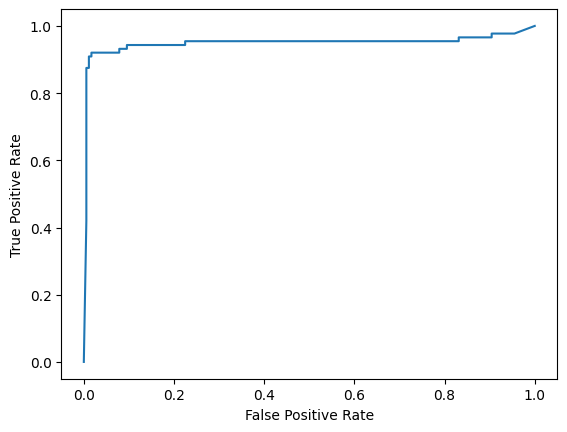

In [38]:
plot_roc_curve(y_relu, y_prob_relu)

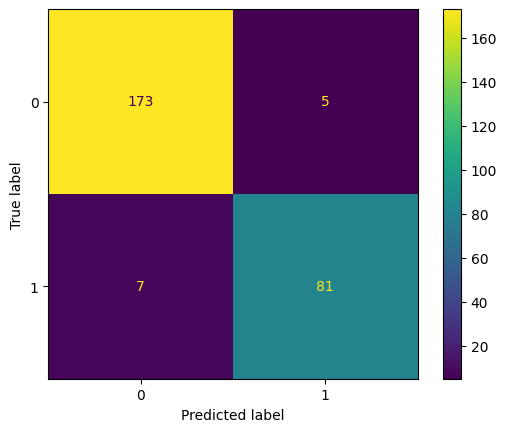

In [39]:
y_pred_relu = [y.round() for y in y_prob_relu]
cf_mat = confusion_matrix(y_relu, y_pred_relu)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat)
disp.plot()
plt.show()